In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
!pip install ipyplot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd 
from sklearn.utils import shuffle
import ipyplot
from tensorflow.keras.layers import*
from tensorflow.keras.models import*
from tensorflow.keras.losses import*
from tensorflow.keras.optimizers import*
import os
import math
from sklearn.metrics import accuracy_score, confusion_matrix,ConfusionMatrixDisplay


        WARNING! Google Colab Environment detected!
        You might encounter issues while running in Google Colab environment.
        If images are not displaying properly please try setting `force_b64` param to `True`.
        


## **data preprocessing images**

In [ ]:
def power_law(img, gamma):
    max_val = np.max(img)
    pow_img = max_val * (pow(img / max_val, gamma))
    pow_img = np.array(pow_img, np.uint8)
    return pow_img


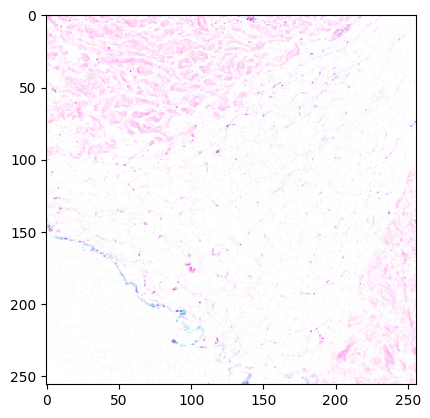

In [ ]:
img = cv2.imread("/content/drive/MyDrive/Colab Notebooks/BCC_9_0027.png")
img.shape
img_show = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_show);

In [ ]:
gamma_corrected_img = power_law(img, 6.5)

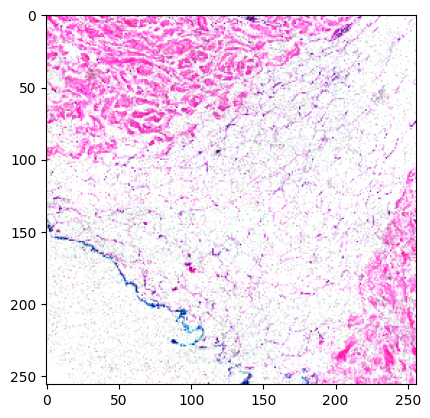

In [ ]:
img_show = cv2.cvtColor(gamma_corrected_img, cv2.COLOR_BGR2RGB)
plt.imshow(img_show)

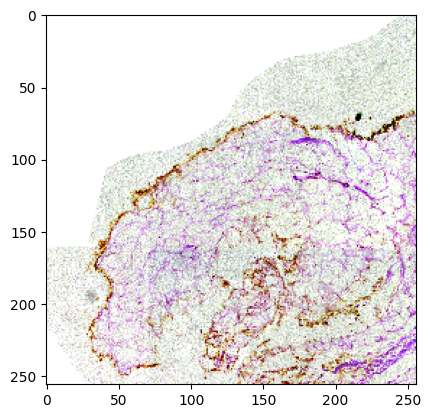

In [ ]:
images = np.load('/content/drive/MyDrive/DIP_Project/Training_images.npy')

processed_images = [] 
for i in range(len(images)):
    processed_image = power_law(images[i],6.5)
    processed_images.append(processed_image)

for i in range(10):
    plt.imshow(processed_images[20+i])
    plt.show()

np.save('/content/drive/MyDrive/DIP_Project/inputs/img',processed_images)


In [ ]:
images_testing = np.load('/content/drive/MyDrive/DIP_Project/Testing_images.npy')

processed_images_testing = [] 
for i in range(len(images_testing)):
    processed_image_testing = power_law(images_testing[i],6.5)
    processed_images_testing.append(processed_image_testing)

for i in range(10):
    plt.imshow(processed_images_testing[20+i])
    plt.show()
np.save('/content/drive/MyDrive/DIP_Project/inputs/img_test',processed_images_testing)

## **data preprocessing masks**

In [ ]:

labels_dictionary = {
    0: [115, 0, 108],
    1: [122, 1, 145],
    2: [148, 47, 216],
    3: [242, 246, 254],
    4: [130, 9, 181],
    5: [157, 85, 236],
    6: [106, 0, 73],
    7: [168, 123, 248],
    8: [0, 0, 0],
    9: [255, 255, 127],
    10: [142, 255, 127],
    11: [127, 127, 255]}


In [ ]:
def label_the_image(image):
    r, c, _ = image.shape
    labeled_image = np.full((r, c), 8, dtype=np.uint8) 
    label_keys = labels_dictionary.keys()
    for i, key in enumerate(label_keys):
        color = labels_dictionary[key]
        mask = np.all(image == color, axis=2)
        labeled_image[mask] = i
    return labeled_image


In [ ]:
def get_original_image(labeled_image):
    r, c = labeled_image.shape[:2]
    decoded_image = np.zeros((r, c, 3), dtype=np.uint8)
    label_keys = labels_dictionary.keys()
    for i in label_keys:
        color = labels_dictionary[i]
        decoded_image[labeled_image == i] = color
    return decoded_image


In [ ]:
img1 = cv2.imread("/content/drive/MyDrive/Colab Notebooks/IEC_49_0024.png")

img_show1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
plt.imshow(img_show1);

In [ ]:
img2=label_the_image(img1)
img3 = get_original_image(img2)
print(np.shape(img2))
print(np.shape(img3))
img_show2 = cv2.cvtColor(img3, cv2.COLOR_BGR2RGB)
plt.imshow(img_show2);

In [ ]:
masks_testing = np.load('/content/drive/MyDrive/DIP_Project/Testing_mask.npy')
masks_training = np.load('/content/drive/MyDrive/DIP_Project/train_mask.npy')

In [ ]:
np.shape(masks_testing),np.shape(masks_training)


In [ ]:
Label_masks_training = [] 
for i in range(len(masks_training)):
    processed_mask = label_the_image(masks_training[i])
    Label_masks_training.append(processed_mask)

NameError: ignored

In [ ]:
Label_masks_testing = [] 
for i in range(len(masks_testing)):
    processed_mask = label_the_image(masks_testing[i])
    Label_masks_testing.append(processed_mask)


In [ ]:
np.shape(Label_masks_training),np.shape(Label_masks_testing)



In [ ]:
Label_masks_testing = np.array(Label_masks_testing)

# Check and correct values exceeding the range
Label_masks_testing[Label_masks_testing >= 12] = 8

# Perform one-hot encoding
num_classes = 12
test_label = tf.keras.utils.to_categorical(Label_masks_testing, num_classes=12)
test_label.shape
test_label.dtype

In [ ]:
#train_label = tf.keras.utils.to_categorical(Label_masks_training, num_classes=12, dtype=np.uint8)
Label_masks_training = np.array(Label_masks_training)

# Check and correct values exceeding the range
Label_masks_training[Label_masks_training >= 12] = 8

# Perform one-hot encoding
num_classes = 12
train_label = tf.keras.utils.to_categorical(Label_masks_training, num_classes=12)
train_label.shape
train_label.dtype

In [ ]:
train_label = train_label.astype(np.uint8)
test_label = test_label.astype(np.uint8)

In [ ]:
np.save('/content/drive/MyDrive/DIP_Project/inputs/train_labels',train_label)
np.save('/content/drive/MyDrive/DIP_Project/inputs/test_label',test_label)

In [ ]:
#actual code

## **Segmetation**

In [ ]:
images_test=np.load('/content/drive/MyDrive/DIP_Project/inputs/img_test.npy')
images_train=np.load('/content/drive/MyDrive/DIP_Project/inputs/img.npy')
train_label=np.load('/content/drive/MyDrive/DIP_Project/inputs/train_labels.npy')
test_label=np.load('/content/drive/MyDrive/DIP_Project/inputs/test_label.npy')

In [ ]:
images_train, train_label = shuffle(images_train, train_label)
images_test,test_label = shuffle(images_test,test_label)


In [ ]:
images_train = (images_train/255).astype('float16')
train_label = (train_label/255).astype('float16')


In [ ]:
images_test = (images_test/255).astype('float16')
test_label = (test_label/255).astype('float16')

In [ ]:
from keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, Input, Dropout, concatenate
from keras.models import Model

In [ ]:
def unet(input_shape, num_classes):
    inputs = Input(input_shape)

    # Encoder
    conv1 = Conv2D(32, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, 3, activation='relu', padding='same')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(512, 3, activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, 3, activation='relu', padding='same')(conv5)
    drop5 = Dropout(0.5)(conv5)

    # Decoder
    up6 = Conv2DTranspose(256, 3, strides=(2, 2), padding='same')(drop5)
    merge6 = concatenate([drop4, up6], axis=3)
    conv6 = Conv2D(256, 3, activation='relu', padding='same')(merge6)
    conv6 = Conv2D(256, 3, activation='relu', padding='same')(conv6)

    up7 = Conv2DTranspose(128, 3, strides=(2, 2), padding='same')(conv6)
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(128, 3, activation='relu', padding='same')(merge7)
    conv7 = Conv2D(128, 3, activation='relu', padding='same')(conv7)

    up8 = Conv2DTranspose(64, 3, strides=(2, 2), padding='same')(conv7)
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(64, 3, activation='relu', padding='same')(merge8)
    conv8 = Conv2D(64, 3, activation='relu', padding='same')(conv8)

    up9 = Conv2DTranspose(32, 3, strides=(2, 2), padding='same')(conv8)
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(32, 3, activation='relu', padding='same')(merge9)
    conv9 = Conv2D(32, 3, activation='relu', padding='same')(conv9)

    conv10 = Conv2D(num_classes, 1, activation='softmax')(conv9)

    model = Model(inputs=inputs, outputs=conv10)

    return model

# Define input shape and number of classes
input_shape = (256, 256, 3)
num_classes = 12

# Create the U-Net model
model = unet(input_shape, num_classes)

# Print the model summary
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 256, 256, 32  896         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_20 (Conv2D)             (None, 256, 256, 32  9248        ['conv2d_19[0][0]']              
                                )                                                           

In [ ]:
images_train.shape, train_label.shape, images_test.shape, test_label.shape

((1200, 256, 256, 3),
 (1200, 256, 256, 12),
 (300, 256, 256, 3),
 (300, 256, 256, 12))

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
model.fit(images_train, train_label,
          batch_size=30,
          epochs=60,
          validation_data= (images_test, test_label),
          )

Epoch 1/50
40/40 [==============================] - 40s 786ms/step - loss: 0.5277 - accuracy: 0.8442 - val_loss: 0.4590 - val_accuracy: 0.8502
Epoch 2/50
40/40 [==============================] - 30s 759ms/step - loss: 0.2447 - accuracy: 0.9147 - val_loss: 0.5113 - val_accuracy: 0.8572
Epoch 3/50
40/40 [==============================] - 31s 771ms/step - loss: 0.1998 - accuracy: 0.9285 - val_loss: 0.5031 - val_accuracy: 0.8632
Epoch 4/50
40/40 [==============================] - 30s 759ms/step - loss: 0.2169 - accuracy: 0.9210 - val_loss: 0.5333 - val_accuracy: 0.8557
Epoch 5/50
40/40 [==============================] - 30s 754ms/step - loss: 0.1796 - accuracy: 0.9354 - val_loss: 0.5431 - val_accuracy: 0.8577
Epoch 6/50
40/40 [==============================] - 30s 756ms/step - loss: 0.1685 - accuracy: 0.9387 - val_loss: 0.5155 - val_accuracy: 0.8646
Epoch 7/50
40/40 [==============================] - 31s 777ms/step - loss: 0.1684 - accuracy: 0.9393 - val_loss: 0.5211 - val_accuracy: 0.8611

In [ ]:
model.save('/content/drive/MyDrive/DIP_Project/model3')

In [ ]:
model.load_weights('/content/drive/MyDrive/DIP_Project/model')

In [ ]:
test_label_pred = model.predict(images_test)

10/10 [==============================] - 5s 230ms/step


In [ ]:
test_label.shape, test_label_pred.shape

((300, 256, 256, 12), (300, 256, 256, 12))

In [ ]:
np.save('/content/drive/MyDrive/DIP_Project/test_preds',test_label_pred)

In [ ]:
test_label_norm = np.argmax(test_label, axis=3)
test_label_pred_norm = np.argmax(test_label_pred, axis=3)

In [ ]:
test_label_norm.shape, test_label_pred_norm.shape

((300, 256, 256), (300, 256, 256))

In [ ]:
m = tf.keras.metrics.MeanIoU(num_classes=12)
m.update_state(test_label_norm, test_label_pred_norm)
m.result().numpy()

0.38167313

In [ ]:
import tensorflow as tf

def dice_coefficient(y_true, y_pred, smooth=1e-7):
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    dice = (2.0 * intersection + smooth) / (union + smooth)
    return dice

In [ ]:
dice_coefficient(test_label.astype(np.float32), test_label_pred)

<tf.Tensor: shape=(), dtype=float32, numpy=0.80653995>

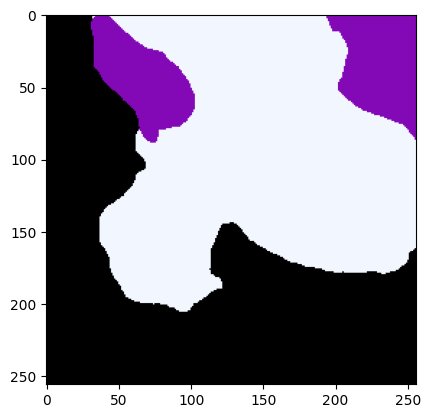

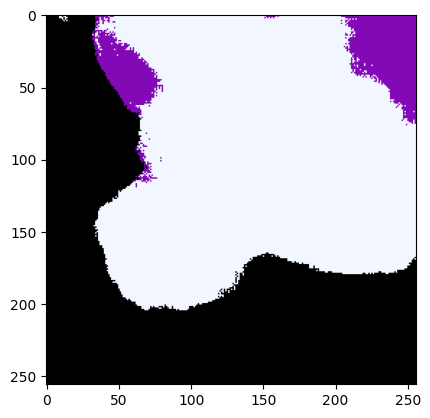

In [ ]:
randChoice = np.random.randint(0, test_label_norm.shape[0])

gorund_truth = get_original_image(test_label_norm[randChoice])
plt.imshow(gorund_truth)

predicted = get_original_image(test_label_pred_norm[randChoice])
plt.figure()
plt.imshow(predicted)